# Initial Test of Facial Keypoint Detector
## Without PCA and an SVM for each class

First we need to identify the keypoint detector model that we will be using. 

MTCNN - Tensorflow
https://github.com/ipazc/mtcnn
(Appears to be pretrained)
It appears to provide a few facial keypoints. May be useful for patch based approach probably not for direct-point position approach.

Pytorch-Facial-Keypoints - Pytorch
https://github.com/fiyero/pytorch_facial_keypoints
(Not pretrained)
Generates keypoints around face but excludes ears. Can be used for direct-point position approach.

Openface - in Lua?
https://github.com/cmusatyalab/openface
(Might be pretrained)
Not sure if it generates keypoints

Openface - 
https://github.com/TadasBaltrusaitis/OpenFace
(Pretrained models)
High number of facial points. Can be used for direct-point position approach.

Facial-Landmark
https://github.com/huohuotm/Facial-Landmark
(pretrained models)
High number of facial points. Can be used for direct-point position approach.

Face-Recognition
https://github.com/ageitgey/face_recognition
(Is pretrained and comes as a library)
Detects facial points.

## Preprocessing images
TODO ?

## Processing on keypoints
TODO ?

## For the classifier
https://scikit-learn.org/stable/modules/svm.html
Recommend Linear SVC first

# The Plan
I am planning on using Face-Recognition which provides a wrapper around dlib face-keypoint-detector. (If we wanted to we could write our own).

Program will read in image, run face-recog for key-points, and store key-points in a CSV file.

Then using the key-points

# Second approach is an end-to-end solution

Something akin to https://github.com/ZER-0-NE/ML_problems

In [1]:
import face_recognition
image = face_recognition.load_image_file("./data/raw/Test/22q11/image_10008_jpg.jpg")
face_landmarks_list = face_recognition.face_landmarks(image)

print(image.shape)
print(face_landmarks_list)

(600, 800, 3)
[{'chin': [(340, 262), (322, 300), (308, 341), (298, 384), (295, 427), (301, 470), (314, 507), (330, 541), (357, 564), (394, 575), (433, 567), (470, 553), (502, 532), (529, 505), (552, 476), (575, 445), (596, 411)], 'left_eyebrow': [(372, 250), (395, 243), (420, 254), (440, 272), (455, 294)], 'right_eyebrow': [(497, 323), (526, 329), (552, 340), (572, 360), (578, 386)], 'nose_bridge': [(459, 338), (445, 365), (431, 391), (417, 420)], 'nose_tip': [(383, 417), (393, 429), (406, 442), (424, 445), (442, 446)], 'left_eye': [(384, 286), (401, 284), (419, 295), (424, 319), (407, 314), (391, 303)], 'right_eye': [(492, 364), (512, 359), (530, 370), (539, 390), (522, 390), (504, 380)], 'top_lip': [(347, 452), (368, 456), (387, 464), (398, 474), (414, 477), (433, 489), (450, 500), (441, 498), (408, 487), (393, 482), (382, 475), (354, 458)], 'bottom_lip': [(450, 500), (423, 508), (398, 506), (382, 500), (369, 491), (356, 475), (347, 452), (354, 458), (379, 478), (391, 486), (406, 491

In [2]:
from PIL import Image, ImageDraw
import face_recognition

# Load the jpg file into a numpy array
image = face_recognition.load_image_file("./data/raw/Test/Angelman/image_161_jpg.jpg")

# Find all facial features in all the faces in the image
face_landmarks_list = face_recognition.face_landmarks(image)

pil_image = Image.fromarray(image)
for face_landmarks in face_landmarks_list:
    d = ImageDraw.Draw(pil_image, 'RGBA')

    # Make the eyebrows into a nightmare
    d.polygon(face_landmarks['left_eyebrow'], fill=(68, 54, 39, 128))
    d.polygon(face_landmarks['right_eyebrow'], fill=(68, 54, 39, 128))
    d.line(face_landmarks['left_eyebrow'], fill=(68, 54, 39, 150), width=5)
    d.line(face_landmarks['right_eyebrow'], fill=(68, 54, 39, 150), width=5)

    # Gloss the lips
    d.polygon(face_landmarks['top_lip'], fill=(150, 0, 0, 128))
    d.polygon(face_landmarks['bottom_lip'], fill=(150, 0, 0, 128))
    d.line(face_landmarks['top_lip'], fill=(150, 0, 0, 64), width=8)
    d.line(face_landmarks['bottom_lip'], fill=(150, 0, 0, 64), width=8)

    # Sparkle the eyes
    d.polygon(face_landmarks['left_eye'], fill=(255, 255, 255, 30))
    d.polygon(face_landmarks['right_eye'], fill=(255, 255, 255, 30))

    # Apply some eyeliner
    d.line(face_landmarks['left_eye'] + [face_landmarks['left_eye'][0]], fill=(0, 0, 0, 110), width=6)
    d.line(face_landmarks['right_eye'] + [face_landmarks['right_eye'][0]], fill=(0, 0, 0, 110), width=6)

    pil_image.show()

In [3]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
X, y = make_classification(n_features=4, random_state=0)
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X, y)
print(clf.coef_)
print(clf.intercept_)
print(clf.predict([[0, 0, 0, 0]]))

[[0.08551853 0.39414771 0.49848086 0.37514369]]
[0.28417571]
[1]


# Load image and generate landmarks

In [4]:
import os
import numpy as np
import face_recognition

LABELS = ['22q11','Angelman','Apert','CDL','Down','FragileX','Marfan','Progeria','Sotos','TreacherCollins','Turner','Williams']


def load_dataset(setPath):
    X = []
    y = []

    for label in LABELS:
        directory = os.path.join(setPath,label)
        for f in os.listdir(directory):
            path = os.path.join(directory,f)
            
            if os.path.isfile(path) and f != 'desktop.ini':
                
                # Extract landmarks
                image = face_recognition.load_image_file(path)
                face_landmarks_list = face_recognition.face_landmarks(image)

                # Iterate through detected faces
                keypoints = []
                for face in face_landmarks_list:

                    # Get face center
                    # and convert points into list form
                    cX = 0
                    cY = 0
                    count = 0
                    points = []

                    for featureType in face.keys():
                        for point in face[featureType]:
                            points = points + list(point)

                            cY = cY + point[0]
                            cX = cX + point[1]
                            count = count + 1
                    cX = cX / count
                    cY = cY / count

                    # Center all points
                    for i in range(0,len(points)):
                        if i % 2 == 0:
                            points[i] = points[i] - cY
                        else:
                            points[i] = points[i] - cX

                    # Store result
                    keypoints.append(points)

                # Append to dataset
                for facePoints in keypoints:
                    X.append(facePoints)
                    y.append(label)
    
    return np.array(X), np.array(y)

In [5]:
X_test, y_test = load_dataset('./data/raw/Test')
print(X_test.shape)
print(y_test.shape)

(312, 144)
(312,)


In [6]:
X_train, y_train = load_dataset('./data/raw/Train')
print(X_train.shape)
print(y_train.shape)

(1023, 144)
(1023,)


SVM Approach

In [7]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
clf.fit(X_train, y_train)
print(clf.coef_)
print(clf.intercept_)

[[ 0.10019801  0.02033238 -0.01293501 ...  0.10311704  0.00382582
  -0.02161245]
 [ 0.04627985 -0.2164234  -0.06763444 ... -0.27987202  0.17123591
   0.09595782]
 [-0.11685209  0.16818827 -0.19210823 ... -0.18054411  0.03257562
  -0.21174519]
 ...
 [ 0.15712787 -0.12318642 -0.12833338 ... -0.25078485 -0.09366315
   0.11903913]
 [ 0.01596341  0.19515915  0.06042189 ... -0.18533853  0.06344362
  -0.02838656]
 [-0.02840746 -0.19262492  0.00243679 ...  0.01597841 -0.16346589
  -0.08416011]]
[-0.27810576 -1.24598348 -0.49805885 -0.92951409 -1.10971039  0.15390712
 -0.36607845 -0.44500052 -0.08861473 -0.75795422  0.08240735 -0.3952285 ]


/home/curt/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 0.7565982404692082


Text(69.0, 0.5, 'Actual')

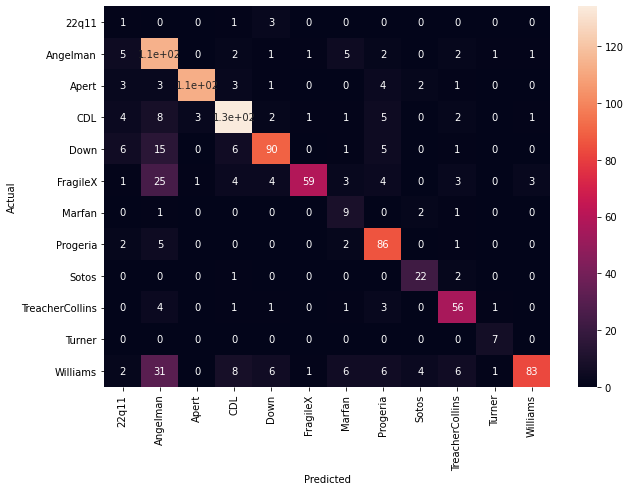

In [9]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.5288461538461539


Text(69.0, 0.5, 'Actual')

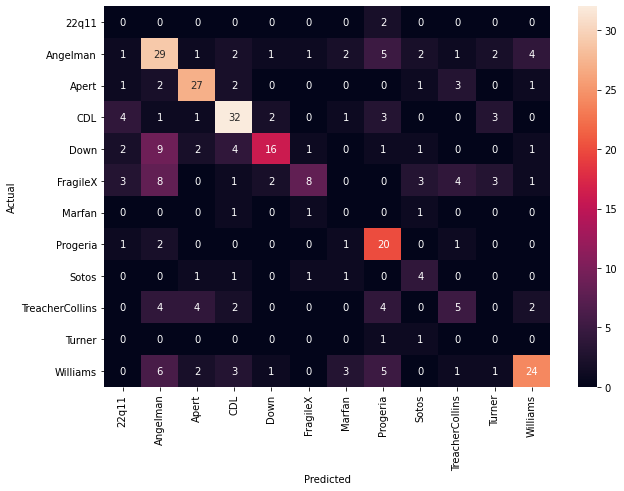

In [11]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

Neural Network Approach

In [12]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 50), max_iter=2000, verbose=True, n_iter_no_change=500)
clf.fit(X_train, y_train)

Iteration 1, loss = 27.51321512
Iteration 2, loss = 8.99645633
Iteration 3, loss = 6.46894491
Iteration 4, loss = 4.74221168
Iteration 5, loss = 4.10814159
Iteration 6, loss = 3.44052281
Iteration 7, loss = 3.13861645
Iteration 8, loss = 2.90075762
Iteration 9, loss = 2.74469972
Iteration 10, loss = 2.92782104
Iteration 11, loss = 2.76789629
Iteration 12, loss = 2.51813997
Iteration 13, loss = 2.55416275
Iteration 14, loss = 2.42667215
Iteration 15, loss = 2.28995731
Iteration 16, loss = 2.30161027
Iteration 17, loss = 2.21417367
Iteration 18, loss = 2.24555934
Iteration 19, loss = 2.31201021
Iteration 20, loss = 2.16477568
Iteration 21, loss = 2.13272977
Iteration 22, loss = 2.05274251
Iteration 23, loss = 2.04744927
Iteration 24, loss = 2.06074234
Iteration 25, loss = 2.00495260
Iteration 26, loss = 2.10890047
Iteration 27, loss = 1.90072182
Iteration 28, loss = 1.86990743
Iteration 29, loss = 1.89678799
Iteration 30, loss = 1.86911099
Iteration 31, loss = 1.82391900
Iteration 32, lo

Iteration 254, loss = 1.18726605
Iteration 255, loss = 1.16743406
Iteration 256, loss = 1.13830806
Iteration 257, loss = 1.15281002
Iteration 258, loss = 1.12489934
Iteration 259, loss = 1.13158710
Iteration 260, loss = 1.23729047
Iteration 261, loss = 1.26966038
Iteration 262, loss = 1.19200252
Iteration 263, loss = 1.20471338
Iteration 264, loss = 1.24908457
Iteration 265, loss = 1.16432886
Iteration 266, loss = 1.17662171
Iteration 267, loss = 1.12901624
Iteration 268, loss = 1.11157318
Iteration 269, loss = 1.11111790
Iteration 270, loss = 1.10371644
Iteration 271, loss = 1.14444440
Iteration 272, loss = 1.11285538
Iteration 273, loss = 1.10678850
Iteration 274, loss = 1.14535236
Iteration 275, loss = 1.19932913
Iteration 276, loss = 1.18855577
Iteration 277, loss = 1.15224816
Iteration 278, loss = 1.22676201
Iteration 279, loss = 1.19641836
Iteration 280, loss = 1.19940373
Iteration 281, loss = 1.13674586
Iteration 282, loss = 1.13847696
Iteration 283, loss = 1.22724554
Iteration 

Iteration 509, loss = 0.79329266
Iteration 510, loss = 0.86646873
Iteration 511, loss = 0.85084332
Iteration 512, loss = 0.94013346
Iteration 513, loss = 0.91566154
Iteration 514, loss = 0.89604150
Iteration 515, loss = 0.85657940
Iteration 516, loss = 0.83035000
Iteration 517, loss = 0.87643458
Iteration 518, loss = 1.03049447
Iteration 519, loss = 1.02434592
Iteration 520, loss = 0.99334014
Iteration 521, loss = 0.99133431
Iteration 522, loss = 1.02001048
Iteration 523, loss = 0.99495042
Iteration 524, loss = 1.04576560
Iteration 525, loss = 1.01677556
Iteration 526, loss = 0.93580211
Iteration 527, loss = 0.86502156
Iteration 528, loss = 0.85222362
Iteration 529, loss = 0.84540154
Iteration 530, loss = 0.88455347
Iteration 531, loss = 0.85363619
Iteration 532, loss = 0.81316968
Iteration 533, loss = 0.81094230
Iteration 534, loss = 0.81446535
Iteration 535, loss = 0.79858013
Iteration 536, loss = 0.85763238
Iteration 537, loss = 0.84312097
Iteration 538, loss = 0.85505272
Iteration 

Iteration 760, loss = 0.69198380
Iteration 761, loss = 0.70605880
Iteration 762, loss = 0.66066819
Iteration 763, loss = 0.66646746
Iteration 764, loss = 0.63879165
Iteration 765, loss = 0.58967510
Iteration 766, loss = 0.59418033
Iteration 767, loss = 0.57748583
Iteration 768, loss = 0.64028474
Iteration 769, loss = 0.60367666
Iteration 770, loss = 0.62400307
Iteration 771, loss = 0.57439869
Iteration 772, loss = 0.71673962
Iteration 773, loss = 0.71241275
Iteration 774, loss = 0.64986986
Iteration 775, loss = 0.65783851
Iteration 776, loss = 0.62726980
Iteration 777, loss = 0.59276312
Iteration 778, loss = 0.58765567
Iteration 779, loss = 0.58328716
Iteration 780, loss = 0.58593549
Iteration 781, loss = 0.60645526
Iteration 782, loss = 0.71116651
Iteration 783, loss = 0.65845205
Iteration 784, loss = 0.65917782
Iteration 785, loss = 0.58445948
Iteration 786, loss = 0.54790815
Iteration 787, loss = 0.66163411
Iteration 788, loss = 0.86621200
Iteration 789, loss = 0.72044001
Iteration 

Iteration 1016, loss = 0.43650530
Iteration 1017, loss = 0.39309201
Iteration 1018, loss = 0.39702712
Iteration 1019, loss = 0.39739195
Iteration 1020, loss = 0.41014752
Iteration 1021, loss = 0.44240798
Iteration 1022, loss = 0.49340663
Iteration 1023, loss = 0.45516246
Iteration 1024, loss = 0.46527059
Iteration 1025, loss = 0.43247079
Iteration 1026, loss = 0.40931685
Iteration 1027, loss = 0.45340901
Iteration 1028, loss = 0.48580777
Iteration 1029, loss = 0.53696040
Iteration 1030, loss = 0.50167109
Iteration 1031, loss = 0.44513524
Iteration 1032, loss = 0.45587181
Iteration 1033, loss = 0.44869453
Iteration 1034, loss = 0.41189316
Iteration 1035, loss = 0.37881615
Iteration 1036, loss = 0.40281436
Iteration 1037, loss = 0.37734487
Iteration 1038, loss = 0.39212879
Iteration 1039, loss = 0.42163091
Iteration 1040, loss = 0.38858359
Iteration 1041, loss = 0.39505602
Iteration 1042, loss = 0.55961061
Iteration 1043, loss = 0.57291314
Iteration 1044, loss = 0.54574374
Iteration 1045

Iteration 1262, loss = 0.27922231
Iteration 1263, loss = 0.30266974
Iteration 1264, loss = 0.30647069
Iteration 1265, loss = 0.27551260
Iteration 1266, loss = 0.27342310
Iteration 1267, loss = 0.26427855
Iteration 1268, loss = 0.32438816
Iteration 1269, loss = 0.35166994
Iteration 1270, loss = 0.35075168
Iteration 1271, loss = 0.34603325
Iteration 1272, loss = 0.29614148
Iteration 1273, loss = 0.30234008
Iteration 1274, loss = 0.30727457
Iteration 1275, loss = 0.30453366
Iteration 1276, loss = 0.32671927
Iteration 1277, loss = 0.30858835
Iteration 1278, loss = 0.31403178
Iteration 1279, loss = 0.33484746
Iteration 1280, loss = 0.29130604
Iteration 1281, loss = 0.29417977
Iteration 1282, loss = 0.31562992
Iteration 1283, loss = 0.30945507
Iteration 1284, loss = 0.35610865
Iteration 1285, loss = 0.35114695
Iteration 1286, loss = 0.36728001
Iteration 1287, loss = 0.37567612
Iteration 1288, loss = 0.38022239
Iteration 1289, loss = 0.34771660
Iteration 1290, loss = 0.31282069
Iteration 1291

Iteration 1513, loss = 0.25020409
Iteration 1514, loss = 0.23635797
Iteration 1515, loss = 0.21965667
Iteration 1516, loss = 0.22487204
Iteration 1517, loss = 0.22981872
Iteration 1518, loss = 0.24396790
Iteration 1519, loss = 0.22227560
Iteration 1520, loss = 0.20107673
Iteration 1521, loss = 0.21923694
Iteration 1522, loss = 0.20928520
Iteration 1523, loss = 0.23050459
Iteration 1524, loss = 0.22411122
Iteration 1525, loss = 0.21512067
Iteration 1526, loss = 0.21538734
Iteration 1527, loss = 0.22559146
Iteration 1528, loss = 0.22680191
Iteration 1529, loss = 0.22207196
Iteration 1530, loss = 0.51864232
Iteration 1531, loss = 0.42960893
Iteration 1532, loss = 0.36261145
Iteration 1533, loss = 0.40492724
Iteration 1534, loss = 0.35109663
Iteration 1535, loss = 0.34853690
Iteration 1536, loss = 0.29230347
Iteration 1537, loss = 0.41141670
Iteration 1538, loss = 0.30908315
Iteration 1539, loss = 0.28939233
Iteration 1540, loss = 0.27184477
Iteration 1541, loss = 0.26244868
Iteration 1542

Iteration 1764, loss = 0.19578337
Iteration 1765, loss = 0.18040290
Iteration 1766, loss = 0.18971475
Iteration 1767, loss = 0.16047897
Iteration 1768, loss = 0.13668113
Iteration 1769, loss = 0.13696253
Iteration 1770, loss = 0.13195897
Iteration 1771, loss = 0.14468870
Iteration 1772, loss = 0.14682992
Iteration 1773, loss = 0.13728526
Iteration 1774, loss = 0.13082192
Iteration 1775, loss = 0.12928939
Iteration 1776, loss = 0.12475213
Iteration 1777, loss = 0.11494486
Iteration 1778, loss = 0.11690562
Iteration 1779, loss = 0.13496100
Iteration 1780, loss = 0.13318809
Iteration 1781, loss = 0.15050932
Iteration 1782, loss = 0.14346183
Iteration 1783, loss = 0.13530124
Iteration 1784, loss = 0.15124589
Iteration 1785, loss = 0.13223398
Iteration 1786, loss = 0.13935067
Iteration 1787, loss = 0.14021068
Iteration 1788, loss = 0.13579834
Iteration 1789, loss = 0.13636823
Iteration 1790, loss = 0.14683814
Iteration 1791, loss = 0.14393995
Iteration 1792, loss = 0.14523273
Iteration 1793

/home/curt/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=500, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 0.9902248289345064


Text(69.0, 0.5, 'Actual')

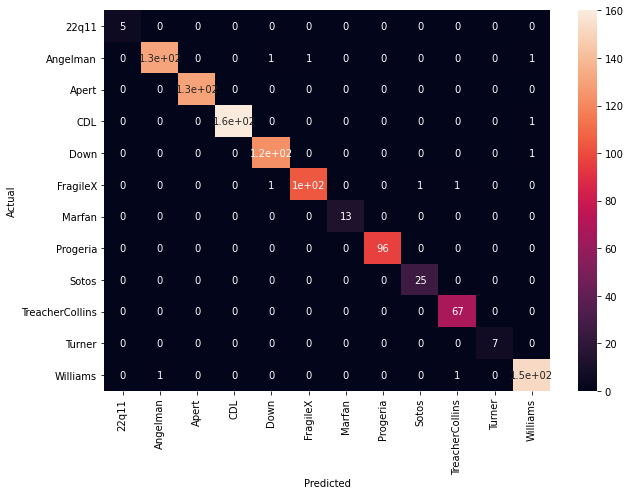

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.5224358974358975


Text(69.0, 0.5, 'Actual')

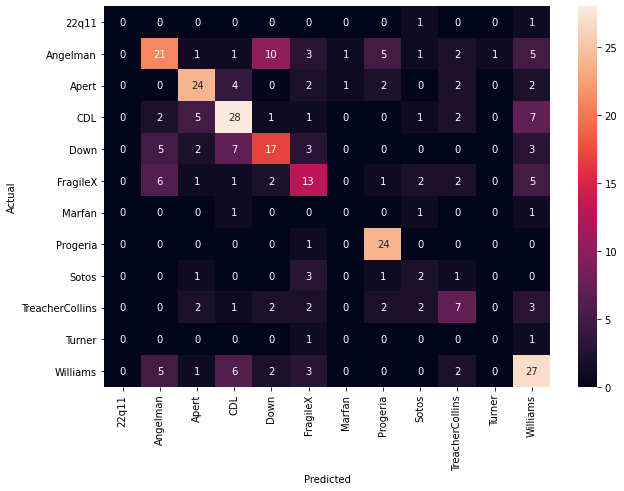

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

PCA SVM

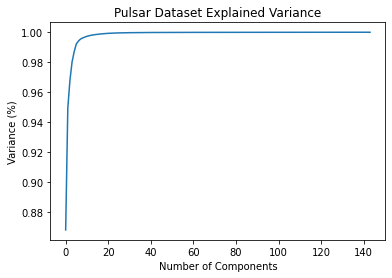

In [17]:
import numpy as np
from sklearn.decomposition import PCA 

pca = PCA().fit(X_train)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [19]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
clf.fit(X_train_pca, y_train)
print(clf.coef_)
print(clf.intercept_)

[[ 6.56095166e-05 -5.13553029e-04  3.20078604e-04 -2.35021580e-04
   7.55408562e-04 -1.00086451e-04  8.60162797e-04 -1.85587610e-04
  -4.91676406e-04  2.68951042e-04 -2.56921237e-04 -5.49847803e-04
   8.70395730e-05  3.58985928e-04  2.77153461e-04]
 [-4.43784639e-04  1.94117618e-03  8.34132110e-04  2.59187524e-03
   1.45780658e-02 -2.00569965e-02 -6.76776822e-03  2.45271291e-02
   7.35529905e-03 -1.47530496e-02  2.87629042e-03 -1.19220699e-03
  -9.89086680e-03  5.48051530e-02 -8.09784921e-03]
 [ 1.09190582e-03 -9.58074697e-04 -3.44240245e-03 -9.37364764e-03
  -8.66137855e-03  3.10497362e-03 -2.60031315e-02  2.66144102e-03
   5.70873078e-02 -4.81380407e-02  5.31063078e-02  6.03228010e-03
   3.63590685e-03  2.42656020e-02 -7.08607375e-03]
 [-2.94780083e-03  3.69806946e-03 -4.28945356e-03 -1.60167167e-02
  -1.26149165e-02  7.02360330e-03  1.70240554e-02 -1.32964703e-02
   8.79519824e-03  2.15412333e-02 -2.07976649e-02  3.85416299e-02
   1.09728018e-02 -3.30396477e-02 -1.41938017e-02]
 [ 1

/home/curt/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train_pca)

accuracy = accuracy_score(y_train, y_pred)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 0.41055718475073316


Text(69.0, 0.5, 'Actual')

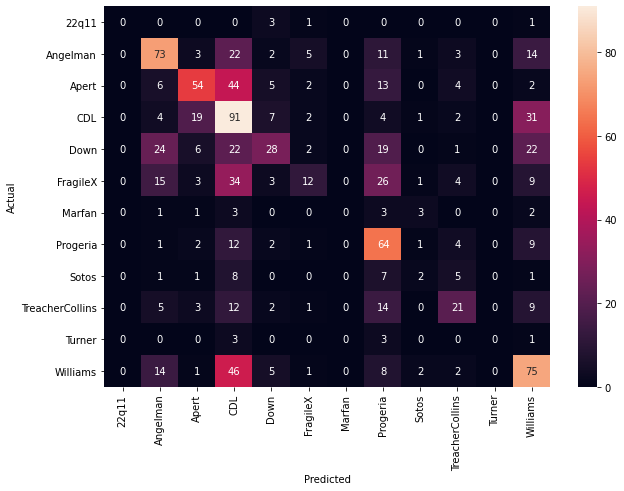

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.33974358974358976


Text(69.0, 0.5, 'Actual')

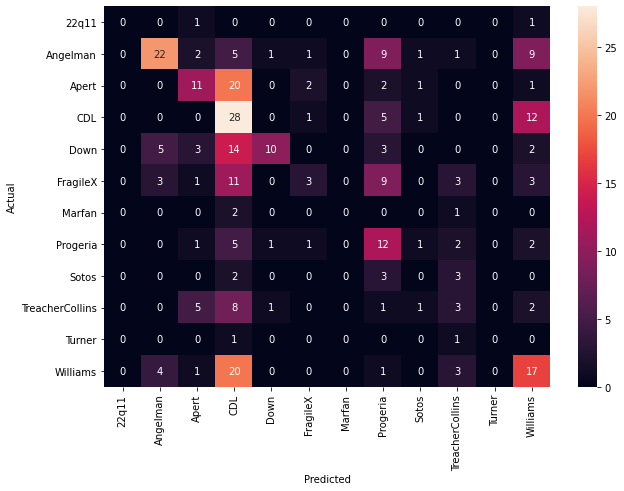

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

PCA Neural Network

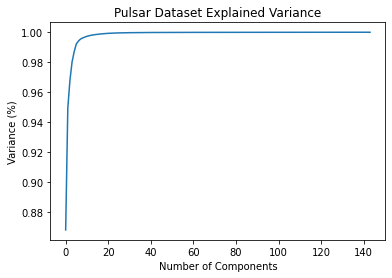

In [24]:
import numpy as np
from sklearn.decomposition import PCA 

pca = PCA().fit(X_train)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [26]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 50), max_iter=2000, verbose=True, n_iter_no_change=500)
clf.fit(X_train_pca, y_train)

Iteration 1, loss = 24.33914687
Iteration 2, loss = 13.90011069
Iteration 3, loss = 9.66082683
Iteration 4, loss = 7.94821018
Iteration 5, loss = 6.24014385
Iteration 6, loss = 5.18622850
Iteration 7, loss = 4.29799333
Iteration 8, loss = 3.78062445
Iteration 9, loss = 3.31747260
Iteration 10, loss = 3.06241966
Iteration 11, loss = 2.82674577
Iteration 12, loss = 2.65492832
Iteration 13, loss = 2.59141158
Iteration 14, loss = 2.34526968
Iteration 15, loss = 2.23321768
Iteration 16, loss = 2.12039745
Iteration 17, loss = 2.04223790
Iteration 18, loss = 1.96828031
Iteration 19, loss = 1.86144297
Iteration 20, loss = 1.82350741
Iteration 21, loss = 1.75744576
Iteration 22, loss = 1.72792515
Iteration 23, loss = 1.68820211
Iteration 24, loss = 1.64368388
Iteration 25, loss = 1.58362083
Iteration 26, loss = 1.57041627
Iteration 27, loss = 1.56493251
Iteration 28, loss = 1.52008429
Iteration 29, loss = 1.53152886
Iteration 30, loss = 1.51213917
Iteration 31, loss = 1.46434120
Iteration 32, l

Iteration 256, loss = 0.42249180
Iteration 257, loss = 0.45001107
Iteration 258, loss = 0.43564419
Iteration 259, loss = 0.45993713
Iteration 260, loss = 0.41908661
Iteration 261, loss = 0.43360968
Iteration 262, loss = 0.44591634
Iteration 263, loss = 0.41899298
Iteration 264, loss = 0.41363996
Iteration 265, loss = 0.41266341
Iteration 266, loss = 0.42861618
Iteration 267, loss = 0.42505674
Iteration 268, loss = 0.43140754
Iteration 269, loss = 0.42162574
Iteration 270, loss = 0.40676212
Iteration 271, loss = 0.40903243
Iteration 272, loss = 0.45241358
Iteration 273, loss = 0.43381202
Iteration 274, loss = 0.40417368
Iteration 275, loss = 0.41870621
Iteration 276, loss = 0.40635468
Iteration 277, loss = 0.40340045
Iteration 278, loss = 0.44170260
Iteration 279, loss = 0.43500258
Iteration 280, loss = 0.41944374
Iteration 281, loss = 0.39469998
Iteration 282, loss = 0.38993049
Iteration 283, loss = 0.40074549
Iteration 284, loss = 0.38296820
Iteration 285, loss = 0.40461140
Iteration 

Iteration 516, loss = 0.19615695
Iteration 517, loss = 0.21631686
Iteration 518, loss = 0.19945418
Iteration 519, loss = 0.18844398
Iteration 520, loss = 0.18538175
Iteration 521, loss = 0.20428972
Iteration 522, loss = 0.20757891
Iteration 523, loss = 0.20979803
Iteration 524, loss = 0.18715695
Iteration 525, loss = 0.17902723
Iteration 526, loss = 0.19120346
Iteration 527, loss = 0.19589559
Iteration 528, loss = 0.18911356
Iteration 529, loss = 0.18750852
Iteration 530, loss = 0.18988563
Iteration 531, loss = 0.18735001
Iteration 532, loss = 0.21942274
Iteration 533, loss = 0.23209546
Iteration 534, loss = 0.20204305
Iteration 535, loss = 0.21464653
Iteration 536, loss = 0.19834045
Iteration 537, loss = 0.19556578
Iteration 538, loss = 0.18136813
Iteration 539, loss = 0.17790099
Iteration 540, loss = 0.17439361
Iteration 541, loss = 0.18593469
Iteration 542, loss = 0.20415298
Iteration 543, loss = 0.21654706
Iteration 544, loss = 0.18197651
Iteration 545, loss = 0.18565327
Iteration 

Iteration 776, loss = 0.09800190
Iteration 777, loss = 0.09405200
Iteration 778, loss = 0.11010817
Iteration 779, loss = 0.10637429
Iteration 780, loss = 0.10653348
Iteration 781, loss = 0.09355683
Iteration 782, loss = 0.09143109
Iteration 783, loss = 0.08812689
Iteration 784, loss = 0.09028576
Iteration 785, loss = 0.10343905
Iteration 786, loss = 0.13659776
Iteration 787, loss = 0.12082051
Iteration 788, loss = 0.12109511
Iteration 789, loss = 0.12610380
Iteration 790, loss = 0.14975193
Iteration 791, loss = 0.14353339
Iteration 792, loss = 0.13239473
Iteration 793, loss = 0.13499522
Iteration 794, loss = 0.16611150
Iteration 795, loss = 0.14710339
Iteration 796, loss = 0.20158725
Iteration 797, loss = 0.16655868
Iteration 798, loss = 0.19950935
Iteration 799, loss = 0.34800322
Iteration 800, loss = 0.55531668
Iteration 801, loss = 0.47424930
Iteration 802, loss = 0.35772809
Iteration 803, loss = 0.30964983
Iteration 804, loss = 0.33983148
Iteration 805, loss = 0.33870677
Iteration 

Iteration 1025, loss = 0.04379367
Iteration 1026, loss = 0.04003105
Iteration 1027, loss = 0.04963686
Iteration 1028, loss = 0.04576254
Iteration 1029, loss = 0.04224016
Iteration 1030, loss = 0.04402155
Iteration 1031, loss = 0.05196939
Iteration 1032, loss = 0.04486896
Iteration 1033, loss = 0.04922282
Iteration 1034, loss = 0.04002045
Iteration 1035, loss = 0.04128681
Iteration 1036, loss = 0.04000075
Iteration 1037, loss = 0.07465056
Iteration 1038, loss = 0.07467575
Iteration 1039, loss = 0.05176647
Iteration 1040, loss = 0.05352519
Iteration 1041, loss = 0.05076495
Iteration 1042, loss = 0.04396940
Iteration 1043, loss = 0.04772561
Iteration 1044, loss = 0.07363601
Iteration 1045, loss = 0.09999733
Iteration 1046, loss = 0.08001234
Iteration 1047, loss = 0.07512648
Iteration 1048, loss = 0.05657264
Iteration 1049, loss = 0.07078095
Iteration 1050, loss = 0.04913628
Iteration 1051, loss = 0.04388001
Iteration 1052, loss = 0.05332817
Iteration 1053, loss = 0.05781003
Iteration 1054

Iteration 1272, loss = 0.01759953
Iteration 1273, loss = 0.01999933
Iteration 1274, loss = 0.01818906
Iteration 1275, loss = 0.01779101
Iteration 1276, loss = 0.01713472
Iteration 1277, loss = 0.01742086
Iteration 1278, loss = 0.01880371
Iteration 1279, loss = 0.01907331
Iteration 1280, loss = 0.01828401
Iteration 1281, loss = 0.01756997
Iteration 1282, loss = 0.01935440
Iteration 1283, loss = 0.02721886
Iteration 1284, loss = 0.03774368
Iteration 1285, loss = 0.04927990
Iteration 1286, loss = 0.08230799
Iteration 1287, loss = 0.04489320
Iteration 1288, loss = 0.04098877
Iteration 1289, loss = 0.02709121
Iteration 1290, loss = 0.02874823
Iteration 1291, loss = 0.02684170
Iteration 1292, loss = 0.03007790
Iteration 1293, loss = 0.02068942
Iteration 1294, loss = 0.02164347
Iteration 1295, loss = 0.01908451
Iteration 1296, loss = 0.01632921
Iteration 1297, loss = 0.01763808
Iteration 1298, loss = 0.01792507
Iteration 1299, loss = 0.02477602
Iteration 1300, loss = 0.02199940
Iteration 1301

Iteration 1525, loss = 0.01159394
Iteration 1526, loss = 0.00912100
Iteration 1527, loss = 0.00889025
Iteration 1528, loss = 0.00760607
Iteration 1529, loss = 0.00824287
Iteration 1530, loss = 0.01025735
Iteration 1531, loss = 0.01015273
Iteration 1532, loss = 0.02103712
Iteration 1533, loss = 0.01036346
Iteration 1534, loss = 0.00870885
Iteration 1535, loss = 0.00710773
Iteration 1536, loss = 0.00685957
Iteration 1537, loss = 0.00662630
Iteration 1538, loss = 0.00647197
Iteration 1539, loss = 0.00637490
Iteration 1540, loss = 0.00625575
Iteration 1541, loss = 0.00642852
Iteration 1542, loss = 0.00626623
Iteration 1543, loss = 0.00655863
Iteration 1544, loss = 0.00848248
Iteration 1545, loss = 0.00747820
Iteration 1546, loss = 0.00683906
Iteration 1547, loss = 0.00738635
Iteration 1548, loss = 0.00716209
Iteration 1549, loss = 0.00645528
Iteration 1550, loss = 0.00662985
Iteration 1551, loss = 0.00661095
Iteration 1552, loss = 0.00808965
Iteration 1553, loss = 0.00691245
Iteration 1554

Iteration 1769, loss = 0.00288922
Iteration 1770, loss = 0.00277360
Iteration 1771, loss = 0.00283545
Iteration 1772, loss = 0.00292712
Iteration 1773, loss = 0.00319038
Iteration 1774, loss = 0.00384221
Iteration 1775, loss = 0.00363894
Iteration 1776, loss = 0.00319480
Iteration 1777, loss = 0.00307451
Iteration 1778, loss = 0.00525032
Iteration 1779, loss = 0.01320106
Iteration 1780, loss = 0.00564183
Iteration 1781, loss = 0.01119251
Iteration 1782, loss = 0.00838099
Iteration 1783, loss = 0.00550211
Iteration 1784, loss = 0.00656500
Iteration 1785, loss = 0.00694541
Iteration 1786, loss = 0.00455554
Iteration 1787, loss = 0.00510976
Iteration 1788, loss = 0.00431843
Iteration 1789, loss = 0.00307761
Iteration 1790, loss = 0.00301168
Iteration 1791, loss = 0.00317517
Iteration 1792, loss = 0.00334400
Iteration 1793, loss = 0.00278099
Iteration 1794, loss = 0.00266455
Iteration 1795, loss = 0.00284454
Iteration 1796, loss = 0.00304240
Iteration 1797, loss = 0.00484194
Iteration 1798

/home/curt/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=500, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train_pca)

accuracy = accuracy_score(y_train, y_pred)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 1.0


Text(69.0, 0.5, 'Actual')

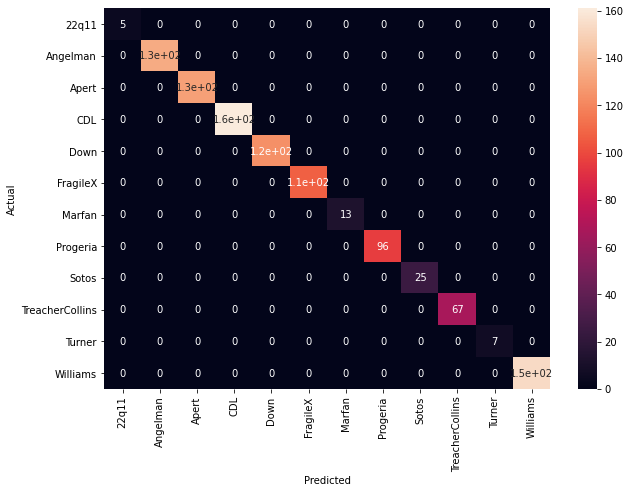

In [28]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.44551282051282054


Text(69.0, 0.5, 'Actual')

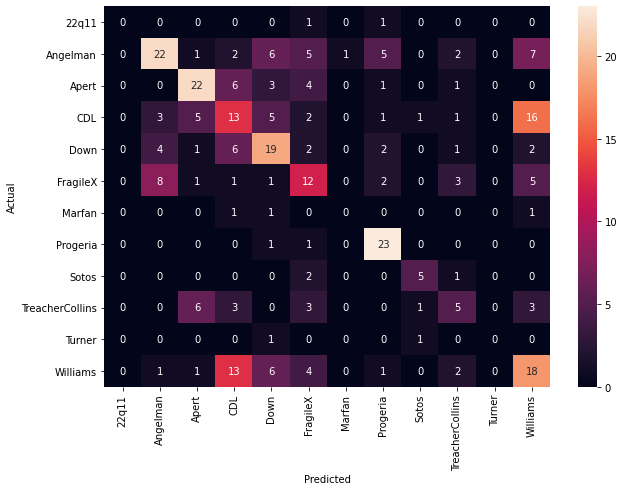

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')